In [60]:
import pandas as pd

In [61]:
url = "https://cve.mitre.org/data/downloads/allitems.csv"
df = pd.read_csv(url, encoding='iso8859_15', header=None, skiprows=10)
df.columns = ['Name', 'Status', 'Description', 'References', 'Phase', 'Votes', 'Comments']

/Users/willnunn/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [62]:
df.head()

,Name,Status,Description,References,Phase,Votes,Comments
0,CVE-1999-0001,Candidate,ip_input.c in BSD-derived TCP/IP implementatio...,BUGTRAQ:19981223 Re: CERT Advisory CA-98.13 - ...,Modified (20051217),"MODIFY(1) Frech | NOOP(2) Northcutt, W...",Christey> A Bugtraq posting indicates that the...
1,CVE-1999-0002,Entry,Buffer overflow in NFS mountd gives root acces...,BID:121 | URL:http://www.securityfocus.com...,NaN,NaN,NaN
2,CVE-1999-0003,Entry,Execute commands as root via buffer overflow i...,BID:122 | URL:http://www.securityfocus.com...,NaN,NaN,NaN
3,CVE-1999-0004,Candidate,"MIME buffer overflow in email clients, e.g. So...",CERT:CA-98.10.mime_buffer_overflows | MS:M...,Modified (19990621),"ACCEPT(8) Baker, Cole, Collins, Dik, Landfi...","Frech> Extremely minor, but I believe e-mail i..."
4,CVE-1999-0005,Entry,Arbitrary command execution via IMAP buffer ov...,BID:130 | URL:http://www.securityfocus.com...,NaN,NaN,NaN


In [63]:
df = df[~df.Description.str.startswith('**')]
df = df[~df.Name.str.contains('2022')]
df = df.set_axis(range(df.shape[0]), axis=0)

In [64]:
desc = df['Description'].str.lower()
desc[0:3]

0    ip_input.c in bsd-derived tcp/ip implementatio...
1    buffer overflow in nfs mountd gives root acces...
2    execute commands as root via buffer overflow i...
Name: Description, dtype: object

In [65]:
from string import digits
desc1 = ['']
remove_digits = str.maketrans("","",digits)
for line in desc:
     desc1.append(line.translate(remove_digits))

In [66]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import gensim
import string

In [67]:
stop_words = stopwords.words('english')

def remove_stop_words(text):
    words = text.split(' ')
    text1 = " ".join([i for i in words if i not in stop_words])
    return text1

In [68]:
def clean_entry(text): 
    delete_dict = {sp_character: '' for sp_character in string.punctuation + string.digits}
    delete_dict[' '] = ' ' 
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)

    return text1

In [69]:
desc1 = desc.apply(remove_stop_words)
desc1 = desc1.apply(clean_entry)

In [70]:
all_stop_words = gensim.parsing.preprocessing.STOPWORDS

def remove_all_stop_words(text):
    words = text.split(' ')
    text1 = " ".join([i for i in words if i not in all_stop_words])
    return text1

In [71]:
desc2 = desc1.apply(remove_all_stop_words)
desc2[0]

'ipinputc bsdderived tcpip implementations allows remote attackers cause denial service crash hang crafted packets'

In [72]:
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from collections import defaultdict
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

desc3 = []
for line in desc2:
    tokens = word_tokenize(line)
    lemma_function = WordNetLemmatizer()
    desc3.append([lemma_function.lemmatize(token, tag_map[tag[0]]) for token, tag in pos_tag(tokens)]) 

In [73]:
desc3[0]

['ipinputc',
 'bsdderived',
 'tcpip',
 'implementation',
 'allow',
 'remote',
 'attacker',
 'cause',
 'denial',
 'service',
 'crash',
 'hang',
 'craft',
 'packet']

In [74]:
vocab = gensim.corpora.Dictionary(desc3)
doc_word_matrix = [vocab.doc2bow(doc) for doc in desc3]

In [75]:
LDA = gensim.models.ldamodel.LdaModel

In [76]:
ldamodel = LDA(corpus=doc_word_matrix, id2word=vocab, num_topics=30)

In [77]:
import pyLDAvis
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(ldamodel, doc_word_matrix, vocab)


/Users/willnunn/opt/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
/Users/willnunn/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/willnunn/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/willnunn/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/willnunn/opt/anaconda3/

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
26     0.133648 -0.016045       1        1  8.141685
12     0.243556  0.012270       2        1  8.133262
23     0.106950 -0.165359       3        1  6.911745
15     0.180667  0.045794       4        1  5.957515
16     0.236485  0.009273       5        1  5.374122
3      0.207772  0.029346       6        1  4.789918
20     0.232777  0.043518       7        1  4.696219
19    -0.042138 -0.288116       8        1  3.959319
1      0.105901  0.114500       9        1  3.772220
24     0.018525 -0.029398      10        1  3.546624
22     0.118906  0.154829      11        1  3.525034
13    -0.072589 -0.145975      12        1  3.101539
27    -0.049356 -0.101840      13        1  2.982353
29     0.070485 -0.048173      14        1  2.907211
14     0.020519  0.100277      15        1  2.650065
4     -0.120837  0.021844      16        1  2.648534
6     -0.104601  0.025969      17        1  2.574449
21    -0.098399 -0.111150      18        1  2.573625
11    -0.149703 -0.114937      19        1  2.479758
17    -0.097355 -0.219033      20        1  2.433985
18     0.030957 -0.085314      21        1  2.268244
7     -0.038409 -0.044274      22        1  2.180003
0     -0.097252  0.090000      23        1  2.144452
2     -0.093673  0.063092      24        1  1.970982
8      0.011025  0.036347      25        1  1.896753
25    -0.134872  0.120228      26        1  1.727531
10    -0.140928  0.064165      27        1  1.605635
28    -0.155049  0.128975      28        1  1.110497
9     -0.164691  0.152589      29        1  1.101351
5     -0.158321  0.156596      30        1  0.835372, topic_info=               Term           Freq          Total Category  logprob  loglift
62    vulnerability  191973.000000  191973.000000  Default  30.0000  30.0000
192         version   73816.000000   73816.000000  Default  29.0000  29.0000
280           issue   46306.000000   46306.000000  Default  28.0000  28.0000
2905          prior   45949.000000   45949.000000  Default  27.0000  27.0000
84        privilege   39682.000000   39682.000000  Default  26.0000  26.0000
...             ...            ...            ...      ...      ...      ...
2371           move      82.176366      83.384905  Topic30  -6.0504   4.7704
930     nonstandard      77.366010      78.574575  Topic30  -6.1107   4.7695
1155          cross    2738.111433    2806.844897  Topic30  -2.5443   4.7603
904          single     362.804544     591.439192  Topic30  -4.5654   4.2964
838      executable     323.736701    1044.873632  Topic30  -4.6794   3.6133

[1400 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
2225      1  0.999848      able
2350     28  0.996180     abort
1702      6  0.996392  absolute
1185     19  0.998005     abuse
1493     11  0.999374        ac
...     ...       ...       ...
560      10  0.901865      zero
560      18  0.096199      zero
2251     23  0.997224       zip
66       27  0.992975      zone
3165     12  0.995180      zope

[2488 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[27, 13, 24, 16, 17, 4, 21, 20, 2, 25, 23, 14, 28, 30, 15, 5, 7, 22, 12, 18, 19, 8, 1, 3, 9, 26, 11, 29, 10, 6])

The outcome of our LDA is interesting. Set the relevance lamba to 0.5 with the slider and examine topic one by moving your cursor over the bubble containing 1. Looking at the words, a human might think it'd be reasonable to title this topic 'buffer overflow attacks'. The unsettling thing about topic one is that it contains almost all instances of the word 'code' and gives thsse word the highest relevance score. I'd expect words like 'code' to be topic-independent, and we shall go on to test whether the inclusion of such a word is indicative of a topic model which has done a poor job. The method will incorporate the time structure of our dataset, and use change point detection. 

Plan is to run cross validated LDA to determine optimal number of topics using coherence as a performance metric. We choose the LDA which has the best performance and zone in on the topic which contains 'buffer' 'overflow'. We then carry out change point detection on the topic through the dataset and compare it with the the changepoint detection of the binary string given by zero if the document doesn't contain 'buffer overflow' and one if it does. In the buffer overflow topic there will be some words which should probably be topic-independent, we again compare the changepoint detection run on these words. Showing that the time aspect of our data set is poorly respected by our topic model.

Perhaps we could even use somethig temporal to inform our topic choices. Frequent (topic worthy) words are investigated, and a density estimate over time is derived for each. Words with less uniform density estimates are considered 'seed' words, and could have their weight (which weight, how?) adjusted in the LDA. Also, it can be said quite confidently that words which have fairly uniform should not be only found in one topic which contains many seed words.

What about placing each seed word into its own topic to begin with, running the bayesian inference, and then combining any 'close' topics together?

# Change Point Detection

In [1]:
!pip install ruptures

     |████████████████████████████████| 392 kB 5.5 MB/s eta 0:00:01


In [4]:
import matplotlib.pylab as plt
import ruptures as rpt
n, dim = 500, 1
n_bkps, sigma = 3, 5
signal, bkps = rpt.pw_constant(n, dim, n_bkps, noise_std=sigma)

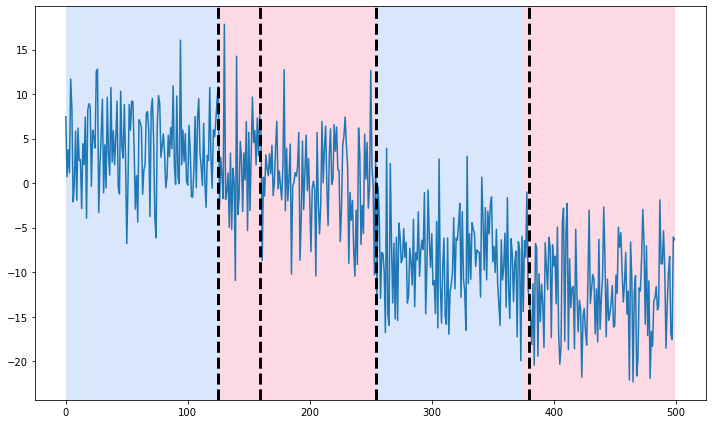

In [9]:
model = "l2"
algo = rpt.Binseg(model=model).fit(signal)
my_bkps = algo.predict(n_bkps=4)

rpt.show.display(signal, bkps, my_bkps, figsize=(10, 6))
plt.show()